# FLX_JP-Swl
partitioning FLUXNET-CH4 data from Lake Suwa into diffusive and ebullitive fluxes

In [29]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P

In [30]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## Import data and process

In [38]:
df = wave.pd_read_from_drive('FLX_JP-Swl') # read from google drive into pd.DataFrame

In [39]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date']) # make DatetimeIndex
df = df.loc[:, ["LE", "FCH4", "TA", "FCH4_F", "TA_F", 'LE_F']] # select all rows, some columns

plot entire FCH4 series vs time

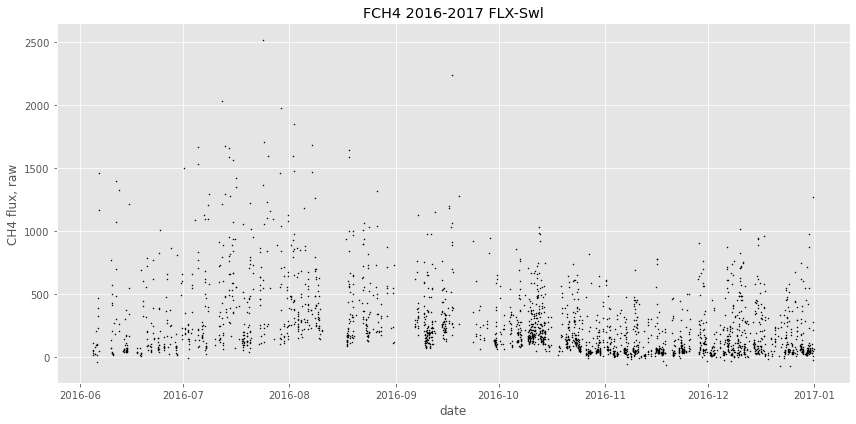

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.index, df['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
ax.set_title("FCH4 2016-2017 FLX-Swl")
plt.tight_layout()

### Summer 2016

select date range 2016-06-10 to 2016-08-10 (leaving off isolated points late evening 08-10)

In [7]:
dfw = df.loc['2016-06-10':'2016-08-10 08:00:00']

plot FCH4 and FCH4_F

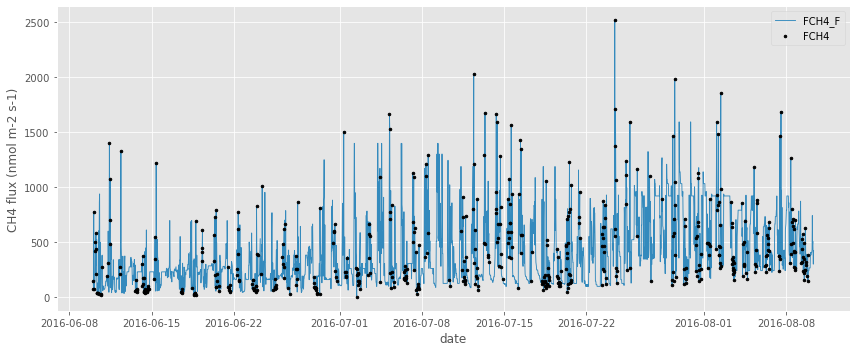

In [8]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(dfw.index, dfw['FCH4_F'], list(plt.rcParams['axes.prop_cycle'])[1]['color'], 
        dfw.index, dfw['FCH4'], 'k.', markersize=5, linewidth=0.9)
ax.set_xlabel('date')
ax.set_ylabel('CH4 flux (nmol m-2 s-1)')
ax.legend(['FCH4_F', 'FCH4'])
plt.tight_layout()

 drop last two points and chop between first and last nans

In [9]:
dfw = dfw[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
dfw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2016-06-10 01:00:00 to 2016-08-09 20:30:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LE      1032 non-null   float64
 1   FCH4    541 non-null    float64
 2   TA      2918 non-null   float64
 3   FCH4_F  2920 non-null   float64
 4   TA_F    2920 non-null   float64
 5   LE_F    2920 non-null   float64
dtypes: float64(6)
memory usage: 159.7 KB


verify that we chopped that first big gap

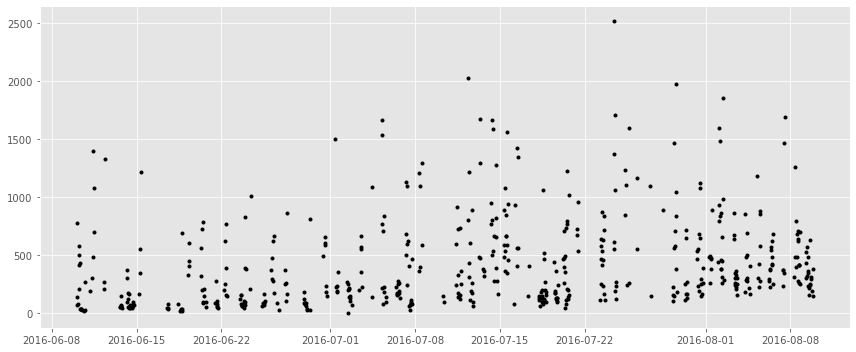

In [10]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dfw.index, dfw['FCH4'], 'k.')
plt.tight_layout()

In [11]:
dfw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2016-06-10 01:00:00 to 2016-08-09 20:30:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LE      1032 non-null   float64
 1   FCH4    541 non-null    float64
 2   TA      2918 non-null   float64
 3   FCH4_F  2920 non-null   float64
 4   TA_F    2920 non-null   float64
 5   LE_F    2920 non-null   float64
dtypes: float64(6)
memory usage: 159.7 KB


In [12]:
nM, [xpM, ypM] = wave.norm(dfw.loc[:, 'FCH4_F'])
nLE, [xpLE, ypLE] = wave.norm(dfw.loc[:, 'LE_F'])
nT, [xpT, ypT] = wave.norm(dfw.loc[:, 'TA_F'])

df.loc[dfw.index, 'FCH4_Fn'] = nM
df.loc[dfw.index, 'LE_Fn'] = nLE
df.loc[dfw.index, 'TA_Fn'] = nT

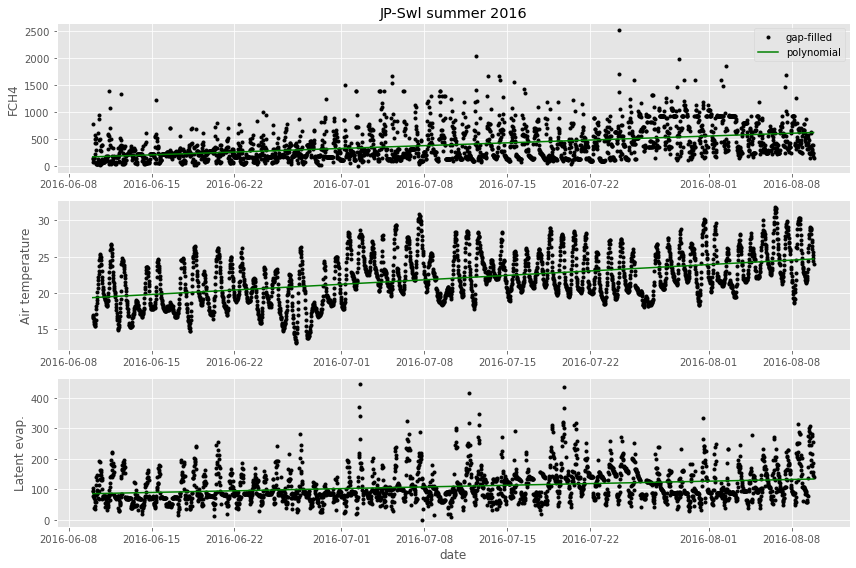

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12,8))

ax[0].plot(dfw.index, dfw['FCH4_F'], 'k.',
        dfw.index, ypM, 'g-')
ax[0].set(ylabel='FCH4', title = 'JP-Swl summer 2016')
ax[0].legend(['gap-filled', 'polynomial'], loc='upper right')

ax[1].plot(dfw.index, dfw['TA_F'], 'k.',
        dfw.index, ypT, 'g-')
ax[1].set(ylabel='Air temperature')

ax[2].plot(dfw.index, dfw['LE_F'], 'k.',
        dfw.index, ypLE, 'g-')
ax[2].set(ylabel='Latent evap.')


ax[-1].set(xlabel='date')

plt.tight_layout()

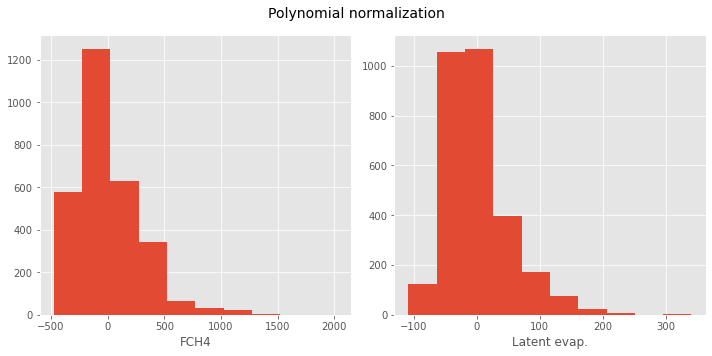

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle('Polynomial normalization', fontsize=14)

ax[0].hist(df.loc[dfw.index, 'FCH4_Fn'])
ax[0].set(xlabel = 'FCH4')

ax[1].hist(df.loc[dfw.index, 'LE_Fn'])
ax[1].set(xlabel='Latent evap.')

plt.tight_layout()

In [16]:
# compute wavelet coefficients using MODWT
cM = wave.mra8(df.loc[dfw.index, 'FCH4_Fn'])
cT = wave.mra8(df.loc[dfw.index, 'TA_Fn'])
cLE = wave.mra8(df.loc[dfw.index, 'LE_Fn'])

# sum wavelet scales and calculate scale windows
csumM, scalesM = wave.sum_scales(cM)
csumT, scalesT = wave.sum_scales(cT)
csumLE, scalesLE = wave.sum_scales(cLE)

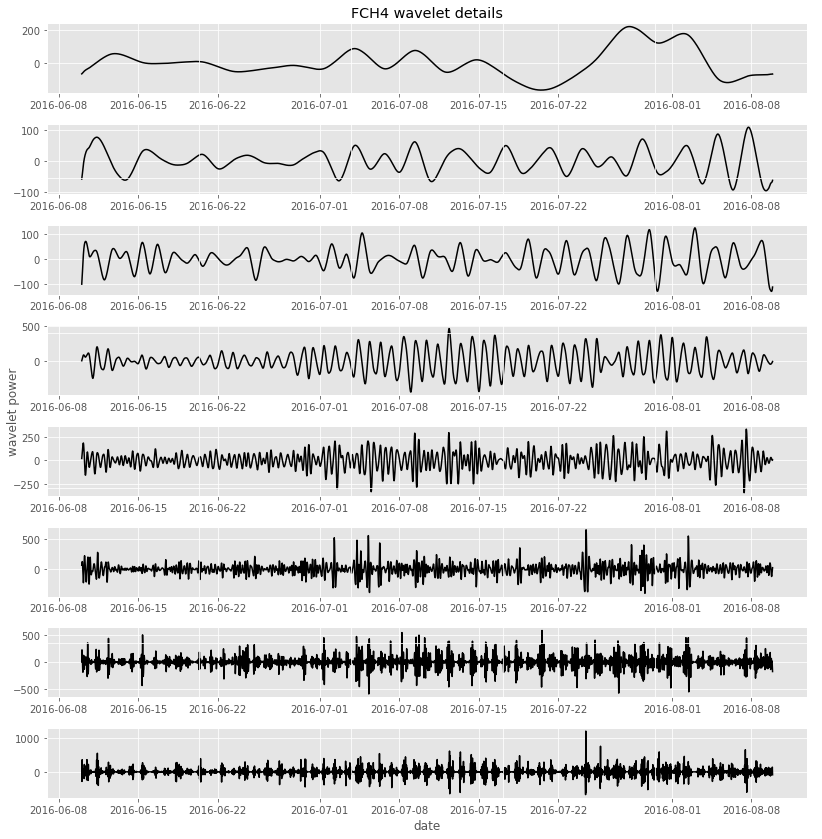

In [17]:
p.wavelet(dfw.index, cM, title = 'FCH4 wavelet details')

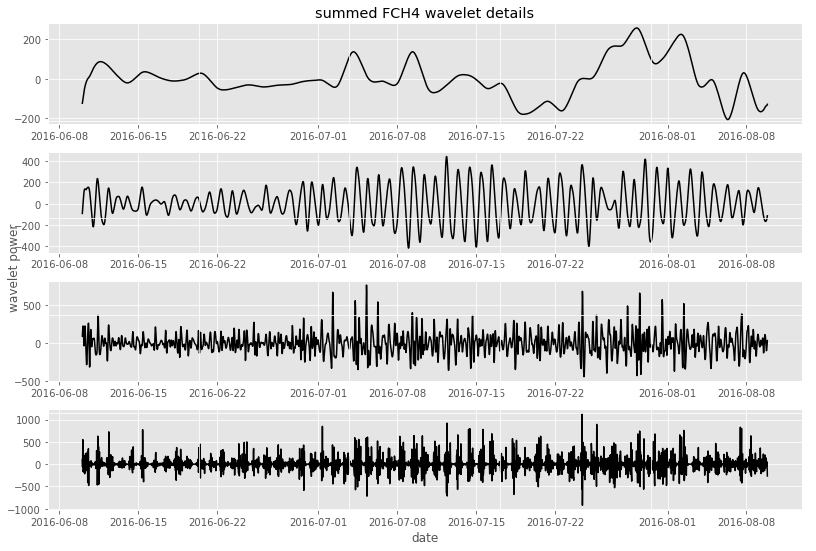

In [18]:
p.wavelet(dfw.index, csumM, title = 'summed FCH4 wavelet details', figsize = (12, 8))

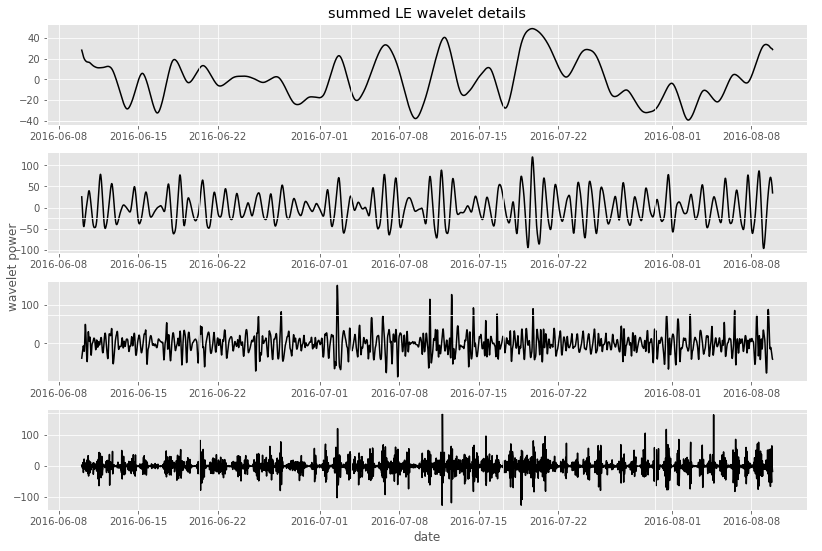

In [19]:
p.wavelet(dfw.index, csumLE, title = 'summed LE wavelet details', figsize = (12, 8))

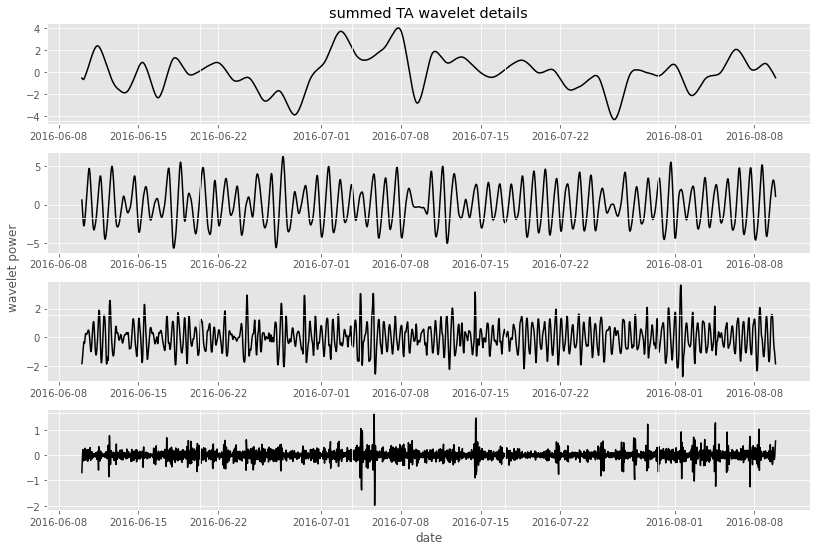

In [20]:
p.wavelet(dfw.index, csumT, title = 'summed TA wavelet details', figsize = (12, 8))

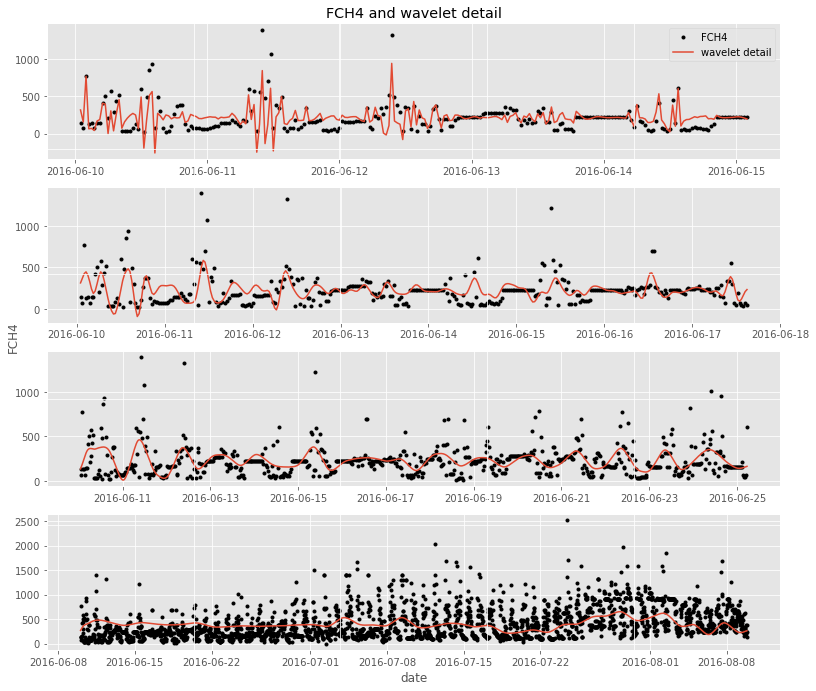

In [21]:
p.reconst(dfw.index, dfw['FCH4_F'], csumM, scalesM, ylabel = 'FCH4', 
            filename = '20210520_FCH4_vs_time_wavedet.jpeg')

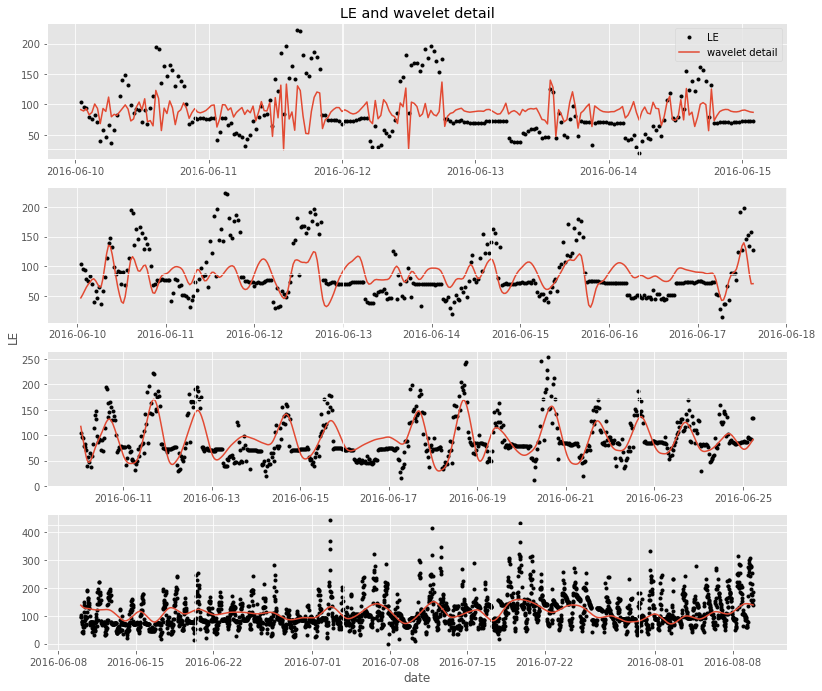

In [22]:
p.reconst(dfw.index, dfw['LE_F'], csumLE, scalesLE, ylabel = 'LE', 
             filename = '20210520_LE_vs_time_wavedet.jpeg')

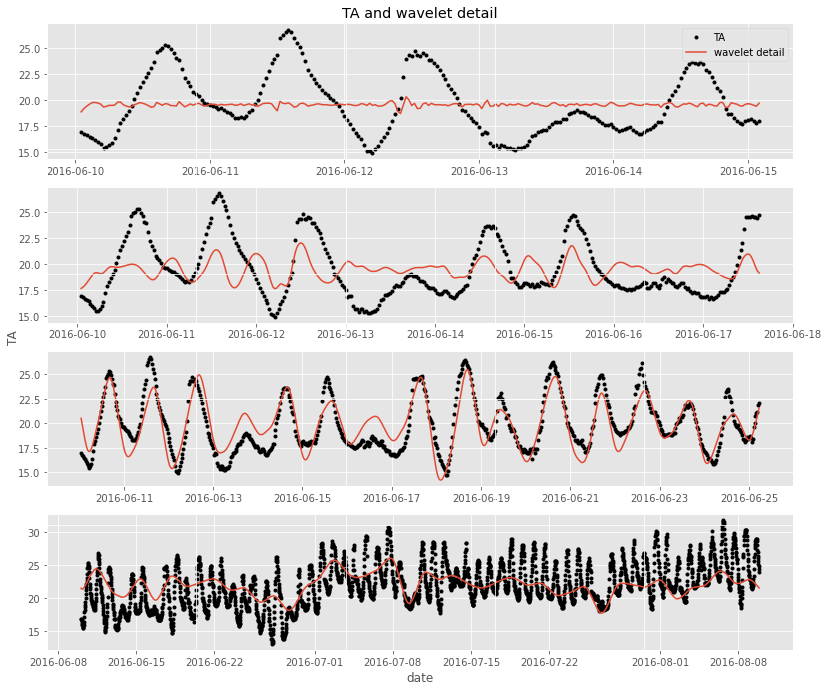

In [23]:
p.reconst(dfw.index, dfw['TA_F'], csumT, scalesT, ylabel = 'TA', 
             filename = '20210520_TA_vs_time_wavedet.jpeg')

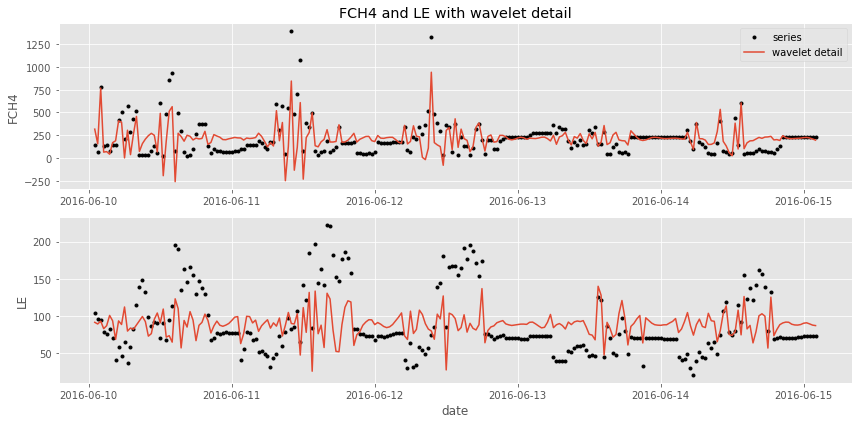

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))

ax[0].plot(dfw.index[:scalesM[-1]], dfw['FCH4_F'][:scalesM[-1]], 'k.',
          dfw.index[:scalesM[-1]], csumM[-1][:scalesM[-1]] + dfw['FCH4_F'][:scalesM[-1]].mean())
ax[1].plot(dfw.index[:scalesLE[-1]], dfw['LE_F'][:scalesLE[-1]], 'k.', 
          dfw.index[:scalesLE[-1]], csumLE[-1][:scalesLE[-1]] + dfw['LE_F'][:scalesLE[-1]].mean())


ax[0].set_ylabel('FCH4')
ax[1].set_ylabel('LE')
ax[0].set(title='FCH4 and LE with wavelet detail')
ax[0].legend(['series', 'wavelet detail'])
ax[-1].set_xlabel('date')
plt.tight_layout()


# if filename is not None:
#     plt.savefig(filename)

plt.show()

scatter of wavelet coefficients

In [27]:
# need to cast as pd.Dataframe to transpose?
cM_pd = pd.DataFrame(csumM).transpose()
cT_pd = pd.DataFrame(csumT).transpose()
cLE_pd = pd.DataFrame(csumLE).transpose()

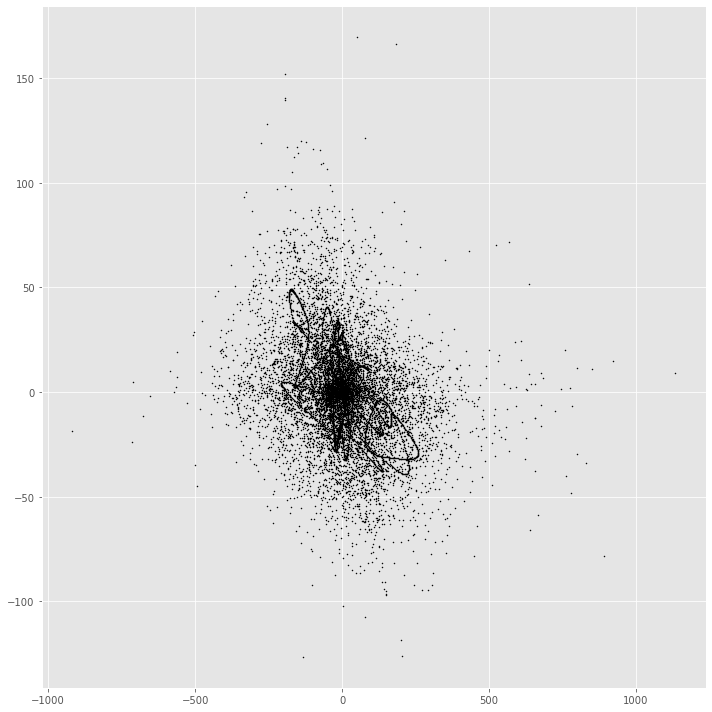

In [28]:
p.scattercoef(cM_pd, cLE_pd)

# junk / test